In [157]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from keras.layers import Conv1D, Add, Activation, Concatenate
from keras.layers import Attention

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from keras import backend as K
import os,random

# ***Utils***

## Dataset loading

In [158]:
def load_data(file_name):
    """Load and preprocess data."""
    df = pd.read_csv("./" + file_name, encoding="ISO-8859-1")
    df = df.dropna(subset=["ProcessedMessage"], axis=0)
    # df.info()
    return df.reset_index(drop=True)

## Get maximum input length

In [159]:
def get_max_input_length(docs):
    """Get the maximum input length from the documents."""
    return max(len(doc.split()) for doc in docs)

## Balance data

In [160]:
def balance_data(X_train, y_train, input_type="numerical"):
    """Oversampling the dataset using SMOTE"""
    counter = Counter(y_train)
    print("Before SMOTE: ", counter)

    if input_type == "text":
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)

    smote_model = SMOTE()
    X_train, y_train = smote_model.fit_resample(X_train, y_train)

    counter = Counter(y_train)
    print("After SMOTE: ", counter)

    if input_type == "text":
        X_train = vectorizer.inverse_transform(X_train)
        for i in range(len(X_train)):
            X_train[i] = " ".join(reversed(X_train[i]))

    return X_train, y_train

## GloVe

In [161]:
def create_embedding_matrix(tokenizer, embedding_dim):
    """Create an embedding matrix using GloVe embeddings."""
    file_name = ""
    embeddings_index = {}
    if embedding_dim == 50:
        file_name = "glove.6B.50d.txt"
    elif embedding_dim == 100:
        file_name = "glove.6B.100d.txt"
    elif embedding_dim == 200:
        file_name = "glove.6B.200d.txt"

    with open("./" + file_name, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

## Text encoding/padding

In [162]:
def encode_text(docs_X_train, docs_X_test):
    """Encode text data into padded sequences."""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(docs_X_train)

    encoded_docs_train = tokenizer.texts_to_sequences(docs_X_train)
    encoded_docs_test = tokenizer.texts_to_sequences(docs_X_test)

    padded_docs_train = pad_sequences(
        encoded_docs_train,
        maxlen=max_sequence_length,
        padding="post",
        truncating="post",
    )
    padded_docs_test = pad_sequences(
        encoded_docs_test, maxlen=max_sequence_length, padding="post", truncating="post"
    )

    return padded_docs_train, padded_docs_test, tokenizer

In [163]:
def build_resnet_block(input_layer, filters, kernel_size):
    """Build a ResNet block with dual channels and spatial attention."""
    # First branch
    x1 = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_layer)
    x1 = Conv1D(filters, kernel_size, padding='same')(x1)
    shortcut1 = Conv1D(filters, kernel_size, padding='same')(input_layer)
    x1 = Add()([x1, shortcut1])
    x1 = Activation('relu')(x1)

    # Second branch
    x2 = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_layer)
    x2 = Conv1D(filters, kernel_size, padding='same')(x2)
    shortcut2 = Conv1D(filters, kernel_size, padding='same')(input_layer)
    x2 = Add()([x2, shortcut2])
    x2 = Activation('relu')(x2)

    # Apply attention mechanism to each branch output
    x1_attention = Attention()([x1, x1])
    x2_attention = Attention()([x2, x2])

    x = Concatenate()([x1_attention, x2_attention])

    return x

DCAR

In [164]:
def DCAR(X_train, X_test, y_train, y_test, params, class_weights, vocab_size, max_sequence_length, embedding_matrix, embedding_dim):
    filters = params["filters"]
    kernel_size = params["kernel_size"]
    epochs = params["epochs"]
    num_resnet_blocks = params.get("num_resnet_blocks", 2)  # Number of ResNet blocks
    # attention_units = params.get("attention_units", 64)    # Number of attention units
    dropout_rate = params.get("dropout_rate", 0.5)          # Dropout rate

    input_layer = tf.keras.layers.Input(shape=(max_sequence_length,))
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length,
                                  weights=[embedding_matrix], trainable=True, mask_zero=True)(input_layer)

    # Build ResNet blocks
    for _ in range(num_resnet_blocks):
        x = build_resnet_block(x, filters, kernel_size)

    # Dual-channel pooling
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    pooled_output = tf.keras.layers.Concatenate()([max_pool, avg_pool])

    x = tf.keras.layers.Dropout(dropout_rate)(pooled_output)  # Dropout layer
    output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Compile and train the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    model.fit(X_train, y_train, class_weight=class_weights, epochs=epochs, verbose=0)

    # Extract feature maps for further analysis or classification
    feature_maps_model = tf.keras.models.Model(model.input, model.get_layer(index=-2).output)
    start_time = time.time()
    X_train_features = feature_maps_model.predict(X_train)
    X_test_features = feature_maps_model.predict(X_test)

    # Balance data if necessary
    X_train_balanced, y_train_balanced = balance_data(X_train_features, y_train)

    # Classify using DCAR_classify function (assuming it's defined elsewhere)
    probs_train, probs_test, y_pred, y_proba = DCAR_classify(X_train_balanced, X_test_features, y_train_balanced, y_test, class_weights)

    # Evaluate model performance
    evaluate_model(y_test, y_pred)
    fpr, tpr, auc = roc(y_test, y_proba)
    end_time = time.time()
    print(end_time-start_time)
    return fpr, tpr, auc

## Classification

In [165]:
def DCAR_classify(X_train, X_test, y_train, y_test, class_weights):
    """Build DCAR's base classifiers (RandomForestClassifier and ExtraTreesClassifier)"""

    classifier1 = RandomForestClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier2 = RandomForestClassifier(
        n_estimators=100,
        criterion="entropy",
        class_weight=class_weights,
        random_state=0,
    )
    classifier3 = ExtraTreesClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier4 = ExtraTreesClassifier(
        n_estimators=100,
        criterion="entropy",
        class_weight=class_weights,
        random_state=0,
    )

    # Classifier 1
    classifier1.fit(X_train, y_train)
    probs_train1 = classifier1.predict_proba(X_train)
    probs_test1 = classifier1.predict_proba(X_test)

    # Classifier 2
    classifier2.fit(X_train, y_train)
    probs_train2 = classifier2.predict_proba(X_train)
    probs_test2 = classifier2.predict_proba(X_test)

    # Classifier 3
    classifier3.fit(X_train, y_train)
    probs_train3 = classifier3.predict_proba(X_train)
    probs_test3 = classifier3.predict_proba(X_test)

    # Classifier 4
    classifier4.fit(X_train, y_train)
    probs_train4 = classifier4.predict_proba(X_train)
    probs_test4 = classifier4.predict_proba(X_test)

    probs_train = np.concatenate(
        (probs_train1, probs_train2, probs_train3, probs_train4), axis=1
    )
    probs_test = np.concatenate(
        (probs_test1, probs_test2, probs_test3, probs_test4), axis=1
    )

    y_pred = []
    y_proba = []
    for i in range(0, len(X_test)):
        avg_ham = (
            probs_test1[i][0]
            + probs_test2[i][0]
            + probs_test3[i][0]
            + probs_test4[i][0]
        ) / 4
        avg_spam = (
            probs_test1[i][1]
            + probs_test2[i][1]
            + probs_test3[i][1]
            + probs_test4[i][1]
        ) / 4
        if avg_ham > avg_spam:
            # ham
            y_pred.append(0)
        else:
            # spam
            y_pred.append(1)

        max_spam = max(
            [probs_test1[i][1], probs_test2[i][1], probs_test3[i][1], probs_test4[i][1]]
        )
        y_proba.append(max_spam)

    return probs_train, probs_test, y_pred, y_proba

## Evaluating

In [166]:
def evaluate_model(y_test, y_pred):
    """Plot confusion matrix and print classification report"""
    target_names = ["Ham", "Spam"]

    # 检查 y_test 和 y_pred 中的类别
    print("Unique classes in y_test:", np.unique(y_test))
    print("Unique classes in y_pred:", np.unique(y_pred))

    # 显式指定 labels 参数
    labels = [0, 1]
    plot_confusion_matrix(y_test, y_pred, target_names)
    print(metrics.classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=4))

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # plt.savefig(f"./Figures/confusion_matrix.pdf")
    plt.show()

def roc(y_test, y_proba):
    """Calculate ROC curve"""
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc = metrics.roc_auc_score(y_test, y_proba)
    print(fpr,tpr,auc)
    return fpr, tpr, auc

# ***Plot ROC for All Models***

In [167]:
def plot_ROC_all(plot_name, result_table):
    """Plot multiple ROC-Curve"""
    fig = plt.figure(figsize=(8, 6))
    for i in result_table.index:
        plt.plot(result_table.loc[i]["fpr"], result_table.loc[i]["tpr"], label="{}, AUC={:.3f}".format(i, result_table.loc[i]["auc"]))
    plt.plot([0, 1], [0, 1], color="orange", linestyle="--")
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.legend(prop={"size": 13}, loc="lower right")
    plt.show()
    # fig.savefig("./Figures/" + plot_name + ".pdf")

# ***Main***

Found 400000 word vectors.
the time of preprocess and glove is 7.7248780727386475

*******************************Run DCAR*******************************

32/32 [==============================] - 1s 33ms/step
Before SMOTE:  Counter({0: 2238, 1: 1743})
After SMOTE:  Counter({0: 2238, 1: 2238})
Unique classes in y_test: [0 1]
Unique classes in y_pred: [0 1]


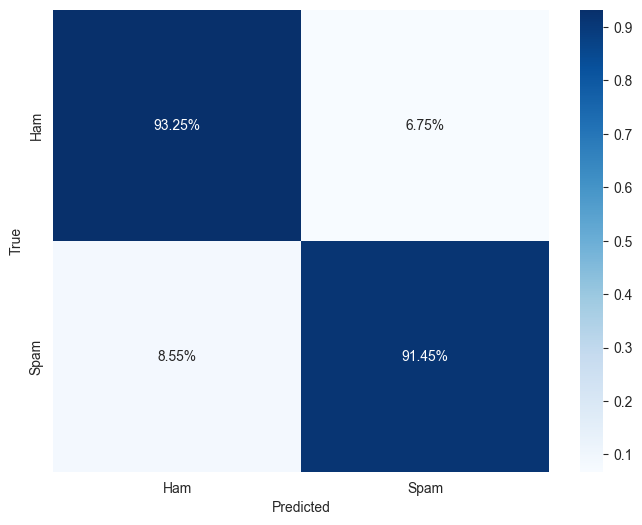

              precision    recall  f1-score   support

         Ham     0.9342    0.9325    0.9333       563
        Spam     0.9124    0.9145    0.9135       433

    accuracy                         0.9247       996
   macro avg     0.9233    0.9235    0.9234       996
weighted avg     0.9247    0.9247    0.9247       996

[0.         0.0053286  0.0053286  0.0053286  0.0053286  0.0053286
 0.0053286  0.0053286  0.0053286  0.0071048  0.0071048  0.0071048
 0.0071048  0.00888099 0.00888099 0.01065719 0.01065719 0.01243339
 0.01243339 0.01420959 0.01420959 0.01776199 0.01776199 0.01953819
 0.01953819 0.02131439 0.02131439 0.02486679 0.02486679 0.03019538
 0.03019538 0.03019538 0.03019538 0.03374778 0.03374778 0.03730018
 0.04085258 0.04262877 0.04262877 0.04440497 0.04618117 0.04618117
 0.04795737 0.05150977 0.05328597 0.05328597 0.05506217 0.05506217
 0.05861456 0.05861456 0.06216696 0.06216696 0.07104796 0.07104796
 0.07282416 0.07282416 0.07460036 0.07460036 0.08348135 0.08348135
 0.08

In [168]:
df = load_data("ExAIS_SMS_SPAM_DATA2.csv")

data = df.drop(["Label"], axis=1)
targets = df["Label"]
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.20, random_state=42)

docs_X_train = X_train["ProcessedMessage"]
docs_X_test = X_test["ProcessedMessage"]
max_sequence_length = get_max_input_length(docs_X_train)
padded_docs_train, padded_docs_test, tokenizer = encode_text(docs_X_train, docs_X_test)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)
end_time = time.time()
params = {"filters": 64, "kernel_size": 3, "units": 64, "epochs": 5}
class_weights = None
print("the time of preprocess and glove is {}".format(end_time-start_time))
print("\n*******************************Run DCAR*******************************\n")
DCAR_fpr, DCAR_tpr, DCAR_auc = DCAR(
    padded_docs_train,
    padded_docs_test,
    y_train,
    y_test,
    params=params,
    class_weights=class_weights,
    vocab_size=vocab_size,
    max_sequence_length=max_sequence_length,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim,
)

print(f"AUC: {DCAR_auc}")